In [5]:
%cd '/mnt/c/Users/malin/Documents/Facultate/honours/UMCG/ICU_Augment_and_Detect'

/mnt/c/Users/malin/Documents/Facultate/honours/UMCG/ICU_Augment_and_Detect


In [6]:
import matplotlib.pyplot as plt
import cv2
import os
import sys
import numpy as np
import pickle
import csv
sys.path.append(os.getcwd())


In [7]:
save_path = 'categorization/model_saves/'
history = '/history.pickle'

models = ["mouth", "face", "skin", "eyes", "stacked"]

all_histories = {}

for model in models:
    hist_path = save_path + str(model) + history
    if os.path.isfile(hist_path):
        print(hist_path)
        hist_file = open(hist_path, "rb")
        all_histories[model] = pickle.load(hist_file)


categorization/model_saves/mouth/history.pickle
categorization/model_saves/face/history.pickle
categorization/model_saves/skin/history.pickle
categorization/model_saves/eyes/history.pickle
categorization/model_saves/stacked/history.pickle


In [42]:
print(all_histories["mouth"])
print(all_histories["face"])

{'loss': [0.35296913726952833, 0.06352210679539928, 0.028465962290395923], 'accuracy': [0.84156376, 0.9907407, 0.9979424], 'auc': [0.93647957, 0.9993335, 0.9999562], 'val_loss': [1.0735337057629146, 0.19433101367306066, 1.9424785633344908], 'val_accuracy': [0.5540541, 0.8918919, 0.6486486], 'val_auc': [0.958734, 0.98717946, 0.72475964]}
{'loss': [0.23972585720657813, 0.02067220949954947, 0.009739666943411524], 'accuracy': [0.9053498, 0.9979424, 0.99897116], 'auc_1': [0.9858129, 0.9999869, 0.9999869], 'val_loss': [11.509664123122757, 5.805893691810402, 1.350943829562213], 'val_accuracy': [0.6486486, 0.6486486, 0.6486486], 'val_auc_1': [0.5, 0.5, 0.4515224]}


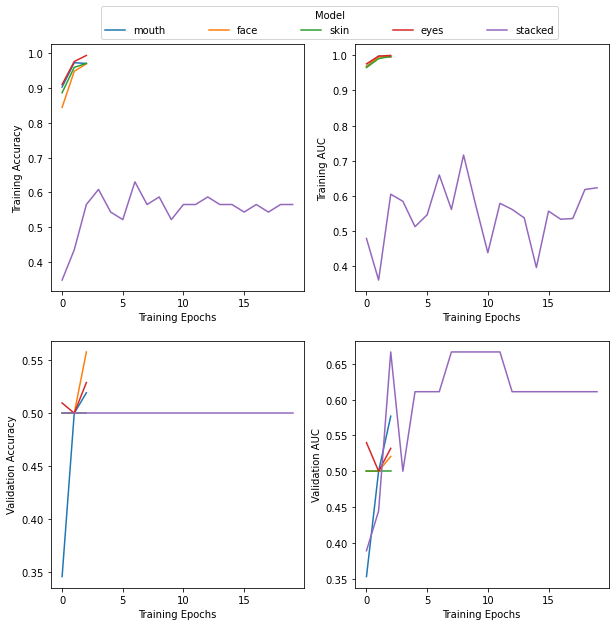

In [10]:
fig = plt.figure(figsize=(10,10))

plt.subplot(2,2,1)
for key in all_histories:
    plt.plot(all_histories[key]["accuracy"], label = str(key))

# plt.xlim((0,2))
plt.xlabel('Training Epochs')
plt.ylabel('Training Accuracy')
# plt.figure()
# plt.legend()
plt.legend(bbox_to_anchor=(0.2, 1.02, 1.8, .102), loc='lower left',
           ncol=5, mode="expand", borderaxespad=0., title = "Model")

plt.subplot(2,2,2)
i = 0
for key in all_histories:
    if i == 0 or i == 4:
        search = "auc"
    else:
        search = "auc_" + str(i)
    plt.plot(all_histories[key][search], label = str(key))
    i +=1 
# plt.xlim((0,2))
plt.xlabel('Training Epochs')
plt.ylabel('Training AUC')
# plt.figure()
# plt.legend()

plt.subplot(2,2,3)
for key in all_histories:
    plt.plot(all_histories[key]["val_accuracy"], label = str(key))

# plt.xlim((0,2))
plt.xlabel('Training Epochs')
plt.ylabel('Validation Accuracy')
# plt.figure()
# plt.legend()

plt.subplot(2,2,4)
i = 0
for key in all_histories:
    if i == 0 or i == 4:
        search = "val_auc"
    else:
        search = "val_auc_" + str(i)
    plt.plot(all_histories[key][search], label = str(key))
    i +=1 

# plt.xlim((0,2))
plt.xlabel('Training Epochs')
plt.ylabel('Validation AUC')
# plt.legend()

plt.savefig("data/plots/models_acc_auc.png")
plt.show()

In [9]:
with open("data/exact_values.csv", "w") as data_file:
    writer = csv.writer(data_file, delimiter=',')
    header = ['Model', 'Training Accuracy', 'Training AUC', 'Validation Accuracy', 'Validation AUC']
    writer.writerow(header)
    i = 0 
    for model in all_histories:
        final = len(all_histories[model]["accuracy"]) - 1
        if i == 0 or i == 4:
            auc = "auc"
            val_auc = "val_auc"
        else:
            auc = "auc_" + str(i)
            val_auc = "val_auc_" + str(i)
        row = [str(model), all_histories[model]["accuracy"][final], all_histories[model][auc][final], all_histories[model]["val_accuracy"][final], all_histories[model][val_auc][final]]
        writer.writerow(row)
        i += 1

